In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.JEB_GINOT import LoadModel
from models import configs
from torch.utils.data import DataLoader
from tqdm import tqdm
import time
import pyvista as pv
import json
import os
from skimage.metrics import normalized_root_mse as NRMSE
from IPython.display import HTML, display_html
device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
# TODO: change backend to "html" for higher resolution and interactive plots
pv_bc="html" # "static", "html", "client"
pv.set_jupyter_backend(pv_bc)
# pv.global_theme.trame.jupyter_extension_enabled = True
# pv.global_theme.trame.server_proxy_enabled = True
if pv_bc == "static":
  window_size = (1280*2, 600*2)
else:
  window_size = (1360, 360)


In [3]:
plot_file_base="./images/"
os.makedirs(plot_file_base, exist_ok=True)
html_names = {"train_best": plot_file_base+"train_best.html",
              "train_50percentile": plot_file_base+"train_50percentile.html",
              "train_worst": plot_file_base+"train_worst.html",
              "test_best": plot_file_base+"test_best.html",
              "test_50percentile": plot_file_base+"test_50percentile.html",
              "test_worst": plot_file_base+"test_worst.html",}
show_edges=False
error_type="nrmse"

In [4]:
configs_jeb = configs.JEB_GINOT_configs()

filebase = configs_jeb["filebase"]
trunk_args = configs_jeb["trunk_args"]
branch_args = configs_jeb["branch_args"]
jeb_ginot = LoadModel(filebase, branch_args, trunk_args)
print("filebase: ", filebase)
print("trunk_args: ", trunk_args)
print("branch_args: ", branch_args)


Total number of parameters of Geo encoder: 690689, 690689 of which are trainable
Total number of parameters of NOT model: 1918850, 1918850 of which are trainable
filebase:  /work/hdd/bdsy/qibang/repository_Wbdsy/GINOT/models/saved_weights/JEB_GINOT
trunk_args:  {'embed_dim': 128, 'cross_attn_layers': 3, 'num_heads': 1, 'dropout': 0.0, 'padding_value': -1000}
branch_args:  {'input_channels': 3, 'out_c': 128, 'latent_d': None, 'width': 128, 'n_point': 512, 'n_sample': 64, 'radius': 0.5, 'd_hidden': [128, 128], 'num_heads': 1, 'cross_attn_layers': 1, 'self_attn_layers': 2, 'fps_method': 'fps', 'pc_padding_val': -1000, 'dropout': 0.0}


In [5]:
train_dataloader, test_dataloader, cells_all, s_inverse, pc_inverse, vert_inverse = configs.LoadDataJEBGeo(
    bs_train=8, bs_test=16, shuffle_loader=False)



Data loading time: 27.33 s


In [6]:


def predict(data_loader, ginot):
    y_pred = []
    y_true = []
    verts_all = []
    pc_all = []
    sample_ids = np.empty(0, dtype=int)
    ginot.eval()
    with torch.no_grad():
        for data in tqdm(data_loader, desc="Predicting"):
            pc = data[0].to(device)  # (B, N, 3)
            xyt = data[1].to(device)  # (B, N, 3)
            y_true_batch = data[2].to(device)  # (B, N)
            mask = (y_true_batch != ginot.padding_value)
            pred = ginot(xyt, pc)
            pred = s_inverse(pred)
            y_true_batch = s_inverse(y_true_batch)
            pred = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                    for x, i in zip(pred, mask)]
            y_true_batch = [x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                            for x, i in zip(y_true_batch, mask)]
            y_pred = y_pred+pred
            y_true = y_true+y_true_batch

            mask_verts = (xyt != configs.PADDING_VALUE).cpu().detach().numpy()
            verts_inv = vert_inverse(xyt)
            verts_all = verts_all+[x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                                   for x, i in zip(verts_inv, mask_verts)]

            mask_pc = (pc != configs.PADDING_VALUE).cpu().detach().numpy()
            pc_inv = pc_inverse(pc)
            pc_all = pc_all+[x[i].view(-1, *i.shape[1:]).cpu().detach().numpy()
                             for x, i in zip(pc_inv, mask_pc)]
            sample_ids = np.append(sample_ids, data[3].cpu().detach().numpy())

    return y_pred, y_true, verts_all, pc_all, sample_ids


def plot_results(pc, u_true, u_pred, cells, verts,
                 label="Mises stress [MPa]", opacity=1.0,
                 pc_color='green', point_size=5.0, cmap="viridis",
                 notebook=None, show_edges=True,
                 html_file=None, window_size=(1024, 256)):
    cell_types = np.full(len(cells), pv.CellType.TETRA)
    mesh_t = pv.UnstructuredGrid(cells.flatten(), cell_types, verts)
    mesh_p = pv.UnstructuredGrid(cells.flatten(), cell_types, verts)
    mesh_e = pv.UnstructuredGrid(cells.flatten(), cell_types, verts)
    true_label = "True "+label
    pred_label = "Pred. "+label
    error_label = "Abs. error [MPa]"
    mesh_t.point_data[true_label] = u_true
    mesh_p.point_data[pred_label] = u_pred
    mesh_e.point_data[error_label] = np.abs(u_pred-u_true)
    plotter = pv.Plotter(shape=(1, 4), notebook=notebook,
                         window_size=window_size)
    # pc mesh
    plotter.subplot(0, 0)
    pc_mesh = pv.PolyData(pc)
    # plotter.reset_camera()
    plotter.add_mesh(pc_mesh, color=pc_color, point_size=point_size)
    plotter.subplot(0, 1)
    plotter.add_mesh(mesh_t, scalars=true_label,
                     show_edges=show_edges, opacity=opacity, cmap=cmap, clim=[np.min(u_true), np.max(u_true)])

    # plotter.reset_camera()
    plotter.subplot(0, 2)
    plotter.add_mesh(mesh_p, scalars=pred_label,
                     show_edges=show_edges, opacity=opacity,
                     cmap=cmap, clim=[np.min(u_true), np.max(u_true)])  #
    plotter.subplot(0, 3)
    plotter.add_mesh(mesh_e, scalars=error_label,
                     show_edges=show_edges, opacity=opacity,
                     cmap=cmap)  #, clim=[0, np.max(u_true)]
    # plotter.reset_camera()
    if html_file is not None:
        plotter.export_html(html_file)
    else:
        plotter.show()


def cal_error(y_pred, y_true,error_type="l2"):

    error_s = []
    for y_p, y_t in zip(y_pred, y_true):
        s_p, s_t = y_p[:], y_t[:]
        if error_type == "l2":
            e_s = np.linalg.norm(s_p-s_t)/np.linalg.norm(s_t)
        elif error_type=="mae":
            e_s = np.mean(np.abs(s_p-s_t))
        elif error_type=="nrmse":
            e_s = NRMSE(s_t, s_p,normalization="min-max")
        else:
            raise ValueError("error_type should be l2 or mae or nrmse")
        error_s.append(e_s)
    error_s = np.array(error_s)
    return error_s


def load_html(file_path):
    # Open and read the HTML file
    with open(file_path, 'r') as file:
        html_content = file.read()
    html_content = f"""
    <div style="width: 100%; height: 600px; ">
        {html_content}
    </div>
    """
    # HTML(html_content) overflow:auto;
    return html_content



In [7]:
# test data
time_start = time.time()
s_pred_test, s_true_test, verts_all_test, pc_all_test, sample_ids_test = predict(
    test_dataloader, jeb_ginot)
time_end = time.time()
print(f"Time taken to predict all samples: {time_end-time_start:.2e} seconds")
print(
    f"Time taken to predict one sample: {(time_end-time_start)/len(s_pred_test):.2e} seconds")



Predicting: 100%|██████████| 14/14 [00:06<00:00,  2.14it/s]

Time taken to predict all samples: 6.54e+00 seconds
Time taken to predict one sample: 3.05e-02 seconds


Mean nrmse error of stress of test dataset: 0.017388370575829204, std: 0.005252667390289295


Text(0, 0.5, 'Frequency')

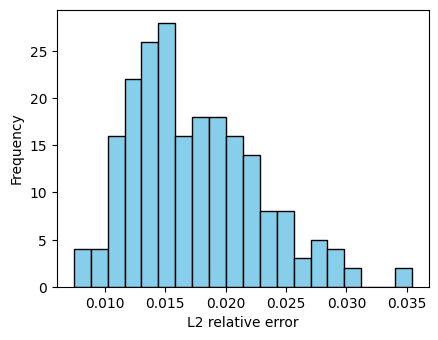

In [8]:
error_s = cal_error(s_pred_test, s_true_test,error_type)
mean, std = np.mean(error_s), np.std(error_s)
print(f"Mean {error_type} error of stress of test dataset: {mean}, std: {std}")
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)
_ = ax.hist(error_s, bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")


In [9]:
# plot the best test sample
sort_idx = np.argsort(error_s)
index = sort_idx[0]

cells_test = cells_all[sample_ids_test[index]]
verts_test = verts_all_test[index]
surface_pc_test = pc_all_test[index]
True_s_test = s_true_test[index]
Pred_s_test = s_pred_test[index]
# plot and save the plot as html
if pv_bc == "html":
  plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
              verts_test, cmap="jet", notebook=True,show_edges=True,window_size=window_size, html_file=html_names["test_best"])
# plot the results here
plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True,show_edges=show_edges,window_size=window_size, html_file=None)
print("l2 error: ", cal_error([Pred_s_test], [True_s_test]))
print(f"{error_type} error: {error_s[index]}")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

l2 error:  [0.16996147]
nrmse error: 0.007427901119033917


In [10]:
# plot the median sample
sort_idx = np.argsort(error_s)
index = sort_idx[int(len(sort_idx) * 0.5)-3]
cells_test = cells_all[sample_ids_test[index]]
verts_test = verts_all_test[index]
surface_pc_test = pc_all_test[index]
True_s_test = s_true_test[index]
Pred_s_test = s_pred_test[index]

if pv_bc == "html":
  plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
              verts_test, cmap="jet", notebook=True,show_edges=True,window_size=window_size, html_file=html_names["test_50percentile"])
# plot the results here
plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True,show_edges=show_edges,window_size=window_size, html_file=None)
print("l2 error: ", cal_error([Pred_s_test], [True_s_test]))
print(f"{error_type} error: {error_s[index]}")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

l2 error:  [0.31265953]
nrmse error: 0.016274991139584152


In [11]:
# plot the worst test sample
sort_idx = np.argsort(error_s)
index = sort_idx[int(len(sort_idx))-1]
cells_test = cells_all[sample_ids_test[index]]
verts_test = verts_all_test[index]
surface_pc_test = pc_all_test[index]
True_s_test = s_true_test[index]
Pred_s_test = s_pred_test[index]

if pv_bc == "html":
  plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
              verts_test, cmap="jet", notebook=True,show_edges=True,window_size=window_size, html_file=html_names["test_worst"])
# plot the results here
plot_results(surface_pc_test, True_s_test, Pred_s_test, cells_test,
             verts_test, cmap="jet", notebook=True,show_edges=show_edges,window_size=window_size, html_file=None)

print("l2 error: ", cal_error([Pred_s_test], [True_s_test]))
print(f"{error_type} error: {error_s[index]}")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

l2 error:  [0.5685222]
nrmse error: 0.03542714872909878


In [12]:
# Training data
time_start = time.time()
s_pred_train, s_true_train, verts_all_train, pc_all_train, sample_ids_train = predict(
    train_dataloader, jeb_ginot)
time_end = time.time()
print(f"Time taken to predict all samples: {time_end-time_start:.2e} seconds")
print(
    f"Time taken to predict one sample: {(time_end-time_start)/len(s_pred_train):.2e} seconds")



Predicting: 100%|██████████| 241/241 [01:20<00:00,  2.99it/s]

Time taken to predict all samples: 8.06e+01 seconds
Time taken to predict one sample: 4.19e-02 seconds


Mean nrmse of stress of training dataset: 0.00768089016181763, std: 0.0016722650838028109


Text(0, 0.5, 'Frequency')

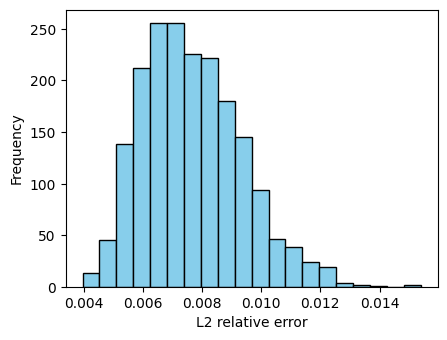

In [13]:
error_s = cal_error(s_pred_train, s_true_train,error_type)
mean, std = np.mean(error_s), np.std(error_s)
print(f"Mean {error_type} of stress of training dataset: {mean}, std: {std}")
fig = plt.figure(figsize=(4.8, 3.6))
ax = plt.subplot(1, 1, 1)
_ = ax.hist(error_s, bins=20,
            color="skyblue", edgecolor="black")
ax.set_xlabel("L2 relative error")
ax.set_ylabel("Frequency")


In [14]:
# plot the train best sample
sort_idx = np.argsort(error_s)
index = sort_idx[0]
print(f"{error_type} error: {error_s[index]}")
cells_train = cells_all[sample_ids_train[index]]
verts_train = verts_all_train[index]
surface_pc_train = pc_all_train[index]
True_s_train = s_true_train[index]
Pred_s_train = s_pred_train[index]
plot_results(surface_pc_train, True_s_train, Pred_s_train, cells_train,
             verts_train, cmap="jet", notebook=None, show_edges=show_edges,window_size=window_size, html_file=html_names["train_best"])

# plot and save the plot as html
if pv_bc == "html":
  plot_results(surface_pc_train, True_s_train, Pred_s_train, cells_train,
              verts_train, cmap="jet", notebook=True,show_edges=True,window_size=window_size, html_file=html_names["train_best"])
# plot the results here
plot_results(surface_pc_train, True_s_train, Pred_s_train, cells_train,
              verts_train, cmap="jet", notebook=True,show_edges=show_edges,window_size=window_size, html_file=None)

print("l2 error: ", cal_error([Pred_s_train], [True_s_train]))
print(f"{error_type} error: {error_s[index]}")

nrmse error: 0.003965704710183864


EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

l2 error:  [0.08701431]
nrmse error: 0.003965704710183864


In [15]:
# plot the train_50percentile sample
sort_idx = np.argsort(error_s)
index = sort_idx[int(len(sort_idx)*0.5)-6]
cells_train = cells_all[sample_ids_train[index]]
verts_train = verts_all_train[index]
surface_pc_train = pc_all_train[index]
True_s_train = s_true_train[index]
Pred_s_train = s_pred_train[index]

# plot and save the plot as html
if pv_bc == "html":
  plot_results(surface_pc_train, True_s_train, Pred_s_train, cells_train,
              verts_train, cmap="jet", notebook=True,show_edges=True,window_size=window_size, html_file=html_names["train_50percentile"])
# plot the results here
plot_results(surface_pc_train, True_s_train, Pred_s_train, cells_train,
              verts_train, cmap="jet", notebook=True,show_edges=show_edges,window_size=window_size, html_file=None)

print("l2 error: ", cal_error([Pred_s_train], [True_s_train]))
print(f"{error_type} error: {error_s[index]}")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

l2 error:  [0.15116912]
nrmse error: 0.00747374985287283


In [16]:
# plot the train worst sample
sort_idx = np.argsort(error_s)
index = sort_idx[int(len(sort_idx))-1]
cells_train = cells_all[sample_ids_train[index]]
verts_train = verts_all_train[index]
surface_pc_train = pc_all_train[index]
True_s_train = s_true_train[index]
Pred_s_train = s_pred_train[index]

# plot and save the plot as html
if pv_bc == "html":
  plot_results(surface_pc_train, True_s_train, Pred_s_train, cells_train,
              verts_train, cmap="jet", notebook=True,show_edges=True,window_size=window_size, html_file=html_names["train_worst"])
# plot the results here
plot_results(surface_pc_train, True_s_train, Pred_s_train, cells_train,
              verts_train, cmap="jet", notebook=True,show_edges=show_edges,window_size=window_size, html_file=None)

print("l2 error: ", cal_error([Pred_s_train], [True_s_train]))
print(f"{error_type} error: {error_s[index]}")

EmbeddableWidget(value='<iframe srcdoc="<!DOCTYPE html>\n<html>\n  <head>\n    <meta http-equiv=&quot;Content-…

l2 error:  [0.23735057]
nrmse error: 0.015392405177760068


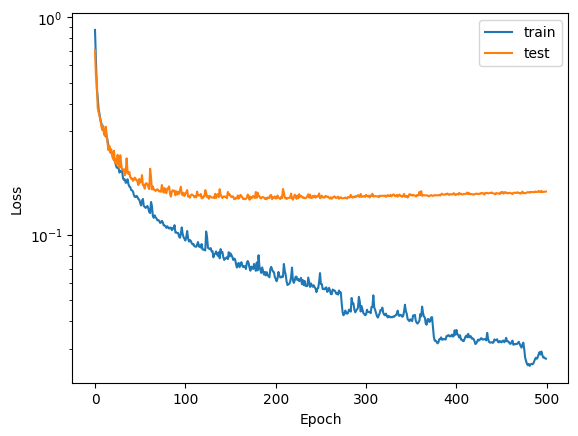

In [17]:
loss_file = filebase + "/logs.json"
with open(loss_file, 'r') as f:
    data = json.load(f)
plt.plot(data['loss'], label='train')
plt.plot(data['val_loss'], label='test')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


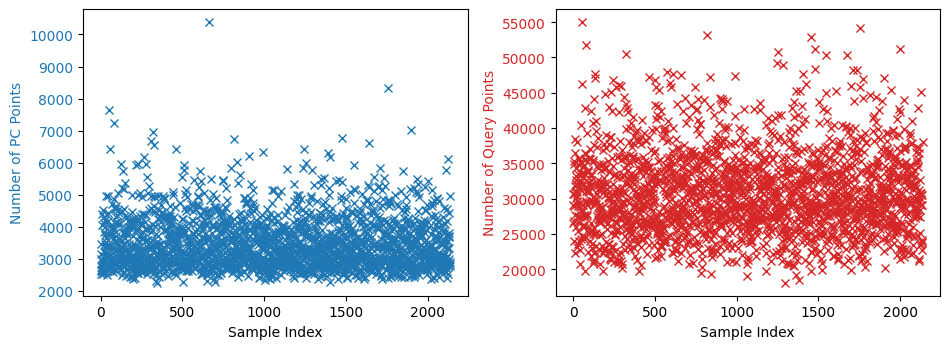

In [18]:
num_pc_point = [len(x) for x in pc_all_train]+[len(x) for x in pc_all_test]
num_query_points = [len(x) for x in verts_all_train] + \
    [len(x) for x in verts_all_test]

fig = plt.figure(figsize=(4.8*2, 3.6))
ax1 = plt.subplot(1, 2, 1)
color = 'tab:blue'
ax1.set_xlabel('Sample Index')
ax1.set_ylabel('Number of PC Points', color=color)
ax1.plot(num_pc_point, 'x', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = plt.subplot(1, 2, 2)
color = 'tab:red'
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Number of Query Points', color=color)
ax2.plot(num_query_points, 'x', color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

In [19]:
# seems HTML can only render one html file in one notebook
# TODO: change the html file name to render other html files
# ["train_best", "train_50percentile", "train_worst",  "test_best","test_50percentile", "test_worst"]
html_file = html_names["test_50percentile"]
html_content = load_html(html_file)
HTML(html_content)
